In [1]:
import numpy as np
#from jax import grad, jacrev, jacfwd, jit, vmap
#import jax.numpy as jnp
#import jax.scipy as jscp

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.svm import SVC

import seaborn as sns
import scipy as scp

import jax
jax.config.update("jax_platform_name", "cpu")

#import matplotlib
#matplotlib.use("pgf")
#matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})


np.random.seed(32)

In [2]:
Phi_g = lambda v: scp.stats.norm.cdf(v, loc=0, scale=1)
phi_g = lambda v: scp.stats.norm.pdf(v, loc=0, scale=1)

In [3]:
def psi_g(alpha, sigma):
    return Phi_g((1- alpha)/sigma) * (1 - alpha) + phi_g((1- alpha)/sigma) * sigma

In [4]:
Phi_m = lambda v: (1 + v/np.sqrt(1 + v**2))/2
Phi_m_prime = lambda v: (1/np.sqrt(1 + v**2)**3)/2
phi_m = lambda v: 1/(2 * np.sqrt(1 + v**2))

The two terms which make up the smooth hinge loss are,
\begin{align*}
    \Phi_m(v) = (1 + v/\sqrt{(1 + v^2)})/2 \\
    \phi_m(v) = 1/(2 \cdot \sqrt{(1 + v^2)}).
\end{align*}

Where the final form is,
\begin{align*}
    \psi_m(v) = \Phi_m(v/\sigma) \cdot v + \phi_m(v/\sigma) \cdot \sigma,
\end{align*}
for $v = 1 - \alpha$ and we use $\alpha = yXw$ for the SVM.

Now, the derivative for the individual terms wrt $v$ is,

\begin{align*}
    \frac{\partial \Phi_m(v)}{\partial v} = \frac{1}{2(v^2+1)^{\frac{3}{2}}} \\
    \frac{\partial \phi_m(v)}{\partial v} = -\frac{v}{2 (v^2 + 1)^{\frac{3}{2}}}
\end{align*}

$(1 + (v/\sigma)/(\sqrt{1+(v/\sigma)^2}))*v/2 + 1/(2\sqrt{(1+(v/\sigma)^2})) * \sigma$
$(1 + (1-\alpha/\sigma)/(\sqrt{1+(1-\alpha/\sigma)^2}))*1-\alpha/2 + 1/(2\sqrt{(1+(1-\alpha/\sigma)^2})) * \sigma$
$(1 + (1-yXw/\sigma)/(\sqrt{1+(1-yXw/\sigma)^2}))*1-yXw/2 + 1/(2\sqrt{(1+(1-yXw/\sigma)^2})) * \sigma$

So, the derivative of the smooth hinge loss for $v = 1 - \alpha$ is,
\begin{align*}
    \frac{\partial \psi_m(v)}{\partial v} &= \left(\frac{\partial \Phi_m(v)}{\partial v} \cdot v + \Phi_m(v) \cdot \frac{\partial v}{\partial \alpha} \right) + \frac{\partial \phi_m(v)}{\partial v} \cdot \sigma \\
    &= \frac{1}{2(v^2+1)^{\frac{3}{2}}} \cdot v - \frac{1}{2}\left(1 + \frac{v}{\sqrt{(1 + v^2)}}\right) -\frac{v}{2 (v^2 + 1)^{\frac{3}{2}}} \cdot \sigma \\
    &= \frac{v(1 - \sigma)}{2(v^2+1)^{\frac{3}{2}}} - \frac{1}{2} - \frac{v}{2(1 + v^2)^{\frac{1}{2}}} \\
    &= \frac{v(1 - \sigma - (1 + v^2))}{2(v^2+1)^{\frac{3}{2}}} - \frac{1}{2}.
\end{align*}

## Gradient descent on derivative by hand
$$
    = -\frac{1}{2} y_i x_i - \frac{1}{2} \left[(1 - y_i w^t x_i)^2 + \sigma^2\right]^{-1/2} (1 - y_i w^T x_i) (-y_i x_i)
$$

In [5]:
def nabla_psi(alpha, sigma):
    v = 1 - alpha
    return (v * (1 - sigma + (1 + v**2)))/(2 * np.sqrt((v**2 + 1))**3) - 1/2

In [6]:
def psi_m(alpha, sigma):
    return Phi_m((1 - alpha)/sigma) * (1 - alpha) + phi_m((1 - alpha)/sigma) * sigma

In [7]:
def hinge_loss(alpha):
    mx = lambda v: max(0, 1 - v)
    return list(map(mx, alpha))

def hinge_loss_grad(alpha):
    piece_wise = lambda v: -1 if v < 1 else 0
    return list(map(piece_wise, alpha))

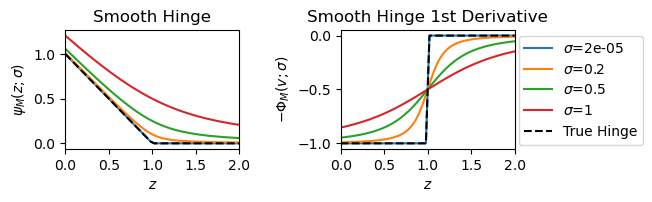

<Figure size 640x480 with 0 Axes>

In [14]:
fig, axs = plt.subplots(1, 2)
xx = np.linspace(0, 2, 50)
sigmas = [2e-5, 2e-1, 5e-1, 1]
for s in sigmas:
    axs[0].plot(xx, psi_m(xx, s), label=f"$\sigma$={s}")
    axs[1].plot(xx, -Phi_m((1 - xx)/s), label=f"$\sigma$={s}")

axs[0].plot(xx, hinge_loss(xx), label="True Hinge", linestyle='--', c='black')
axs[1].plot(xx, hinge_loss_grad(xx), label="True Hinge", linestyle='--', c='black')
axs[0].set_xlabel("$z$")
axs[0].set_ylabel("$\psi_M(z; \sigma)$")
axs[0].set_title("Smooth Hinge")

axs[1].set_title("Smooth Hinge 1st Derivative")
axs[1].set_xlabel("$z$")
axs[1].set_ylabel("$-\Phi_M(v; \sigma)$")

axs[0].set_xlim(0, 2)
axs[1].set_xlim(0, 2)

ws = 1.05 # 1.75
hs = 1.65 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)

labels = [*[f"$\sigma$={s}" for s in sigmas], "True Hinge"]
fig.legend(labels, loc="outside center right", bbox_to_anchor=(1.2, 0.55))

plt.tight_layout()
plt.show()
plt.savefig('smoothhinge_sigma_comb.pgf', bbox_inches='tight', pad_inches=0)

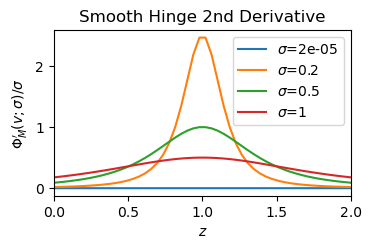

<Figure size 640x480 with 0 Axes>

In [13]:
fig, ax = plt.subplots()
xx = np.linspace(0, 2, 50)
sigmas = [2e-5, 2e-1, 5e-1, 1]
for s in sigmas:
    ax.plot(xx, Phi_m_prime((1 - xx)/s)/s, label=f"$\sigma$={s}")

ax.legend()
ax.set_title("Smooth Hinge 2nd Derivative")
ax.set_xlabel("$z$")
ax.set_ylabel("$\Phi_M^{\prime}(v; \sigma)/\sigma$")

ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
ax.set_xlim(0, 2)
#ax.set_ylim(-1, 1)
plt.tight_layout()
plt.show()
plt.savefig('smoothhinge_sigma_hessian.pgf', bbox_inches='tight', pad_inches=0)

In [10]:
def L(w, X, y, sigma, lbd=0.3):
    return 1/2 * lbd *  np.linalg.norm(w, ord=2)**2 + np.mean(psi_m(y * (X @ w), sigma))

In [11]:
def L_alt(w, X, y, sigma, lbd=0.3):
    return np.mean(psi_m(y * (X @ w), sigma))

In [12]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

NameError: name 'X' is not defined

In [ ]:
clf = SVC(kernel='linear').fit(X, y)
print(clf.coef_)
print(clf.intercept_)

In [ ]:
#X = np.c_[X, np.ones(X.shape[0])]

In [ ]:
print(X.shape)
print(y.shape)

n = X.shape[0]
p = X.shape[1]

In [ ]:
def nabla_psi_X(X, y, w, sigma):
    #numerator = y @ X * (sigma * np.sqrt((1 - y @ X * w/sigma)**2 + 1)**3 + y @ X * w - sigma + 2)
    numerator = (sigma * np.sqrt((1 - y @ X * w/sigma)**2 + 1)**3 + y @ X * w - sigma + 2)
    denom = 2 * sigma * np.sqrt((1 - y @ X * w/sigma)**2 + 1)**3
    return -numerator/denom

In [ ]:
def nabla_fgd(X, y, w, sigma, lbd):
    return (lbd * w - 1/n * y @ X * Phi_m((1 - y @ X * w)/sigma))
    #return (1/2 * y @ X - 1/2 * 1/np.sqrt((1 - y @ X * w)**2 + sigma**2) @ (1 - y @ X * w) * (y @ X))

def nabla_fgd_single(X, y, w, sigma, lbd):
    return (lbd * w - 1/n * y * X * Phi_m((1 - y * X * w)/sigma))
    #return (1/2 * y * X - 1/2 * 1/np.sqrt((1 - y * X * w)**2 + sigma**2) * (1 - y * X * w) * (y * X))

In [ ]:
def hess_fgd(X, y, w, sigma, lbd):
    d = phi_m((1 - y @ X * w)/sigma)
    D = np.eye(n)
    for i in range(n):
        D[i, i] = d[i]
        
    hess = lbd * np.eye(p) + 1/n * (X @ D).T @ X
    return hess

In [ ]:
def hess_fgd_single(X, y, w, sigma, lbd):
    d = phi_m((1 - y * X * w)/sigma)
    D = np.eye(n)
    for i in range(n):
        D[i, i] = d[i]
        
    hess = lbd * np.eye(p) + 1/n * (X @ D).T @ X
    return hess